In [1]:
import copy
import typing as typ

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as func
from tqdm.auto import trange


class FactorizationMachine(nn.Module):
    """Factorization Machine model

    ```math
    f(x|w, v) = w0 + Σwi*xi + ΣΣ<vj, vk>xj*xk
    = w0 + Σwi*xi + 1/2*(Σ(vi*xi)^2 - Σ(vi^2*xi^2))
    ```

    """

    def __init__(self, n_features: int, latent_dim: int):
        """Factroization Machine model

        Args:
            n_features (int): dimension of input features
            latent_dim (int): dimension of latent space
        """
        super(FactorizationMachine, self).__init__()
        self.n_features = n_features
        self.latent_dim = latent_dim

        # weight of 1st order terms
        self.linear = nn.Linear(n_features, 1, bias=True)
        # weight of 2nd order terms
        self.quad = nn.Parameter(torch.randn(n_features, latent_dim) / latent_dim)

    def forward(self, x):
        linear_terms = self.linear(x)

        square_of_sum = torch.pow(torch.matmul(x, self.quad), 2)
        sum_of_square = torch.matmul(x**2, self.quad**2)
        quad_terms = 0.5 * torch.sum(square_of_sum - sum_of_square, dim=1, keepdim=True)

        return linear_terms + quad_terms

    @property
    def v(self):
        return self.quad

    @property
    def w(self):
        return self.linear.weight

    @property
    def w0(self):
        return self.linear.bias


class FMTrainer:
    def __init__(
        self,
        n_features: int,
        latent_dim: int,
        optimizer_params: typ.Optional[dict] = None,
    ):
        self.model = FactorizationMachine(n_features, latent_dim)
        if optimizer_params is None:
            self.optimizer = torch.optim.AdamW(self.model.parameters())
        else:
            self.optimizer = torch.optim.AdamW(
                self.model.parameters(), **optimizer_params
            )
        self._x_numpy = np.array([])
        self._y_numpy = np.array([])

    def fit(self, x_numpy: np.ndarray, y_numpy: np.ndarray, n_epochs: int):
        x = torch.tensor(x_numpy, dtype=torch.float32)
        y = torch.tensor(y_numpy, dtype=torch.float32).view(-1, 1)
        dataset = torch.utils.data.TensorDataset(x, y)
        train_set, test_set = torch.utils.data.random_split(dataset, (0.8, 0.2))
        train_loader = torch.utils.data.DataLoader(
            train_set, batch_size=8, shuffle=True
        )
        test_loader = torch.utils.data.DataLoader(test_set, batch_size=8, shuffle=True)

        # 学習の実行
        min_loss = 1e18  # 損失関数の最小値を保存
        best_state = self.model.state_dict()  # モデルの最も良いパラメータを保存
        for _ in trange(n_epochs, leave=False):
            for x_batch, y_batch in train_loader:
                self.optimizer.zero_grad()
                y_pred = self.model(x_batch)
                loss = func.mse_loss(y_pred, y_batch)
                loss.backward()
                self.optimizer.step()

            # Early Stopping
            patience = 10  # 我慢するエポック数
            min_loss = float("inf")
            patience_counter = 0
            with torch.no_grad():
                for x_batch, y_batch in test_loader:
                    y_pred = self.model(x_batch)
                    loss = func.mse_loss(y_pred, y_batch)

                    if loss < min_loss:
                        min_loss = loss
                        patience_counter = 0
                        best_state = copy.deepcopy(self.model.state_dict())
                    else:
                        patience_counter += 1
            if patience_counter > patience:
                break
        self.model.load_state_dict(best_state)

    def predict(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

    @property
    def x(self):
        return self._x_numpy

    @property
    def y(self):
        return self._y_numpy

    def get_qubo(self) -> tuple[np.ndarray, float]:
        w = self.model.linear.weight.data.numpy().flatten()
        w0 = self.model.linear.bias.data.numpy().flatten()
        q = np.diag(w)
        v = self.model.quad.data.numpy()
        # <vi, vj> = Σ_f v_if * v_jf
        # (v @ v.T)_ij = Σ_f v_if * v_jf
        vv = v @ v.T
        vv = vv - np.diag(np.diag(vv))
        q += 1 / 2 * vv
        return q, float(w0)

In [2]:
# --- ブラックボックス関数の定義 ---
# (最適化アルゴリズムはこの内部を知らないという想定)

clauses = []
with open("ramsey_wt-ram_k3_n11.ra1.wcnf") as f:
    for line in f:
        if line.startswith("c"):
            continue
        else:
            w, *clause = line.split()
            w = int(w)
            clause = [int(lit) for lit in clause]
            assert clause.pop() == 0
            clauses.append((w, clause))

N = max(abs(lit) for _w, clause in clauses for lit in clause)

class BlackboxFunc:
    def __init__(self, N: int, clauses: list[list[int]]) -> None:
        self.N = N
        self.clauses = clauses
    
    def __call__(self, x: np.ndarray) -> float:
        cost = sum(w for w, clause in clauses if sum(x[lit - 1] if lit > 0 else 1 - x[- lit - 1] for lit in clause) <= 0)
        return cost

black_box_function = BlackboxFunc(N, clauses)

In [3]:
# 最適解

optimal_value = 318
optimal_sol = np.zeros(shape=N, dtype=np.int8)
for x in [3, 5, 6, 7, 8, 9, 11, 12, 16, 17, 18, 19, 20, 21, 22, 26, 27, 28, 31, 33, 35, 36, 37, 40, 41, 44, 46, 47, 49, 50, 53, 54]:
  optimal_sol[x-1] = 1

assert black_box_function(optimal_sol) == optimal_value

In [4]:
# --- FMA設定 ---
num_total_evaluations = 1000  # ブラックボックス関数の総評価回数
num_initial_points = 100  # 初期ランダムサンプリング数
k_fm = 10  # Factorization Machine の因子ベクトルの次元 (k)
fm_learning_rate = 0.01
fm_epochs_per_iteration = 50  # 各FMA反復でのFM学習エポック数
num_reads_sa = 50  # OpenJij SA の num_reads

In [5]:
fm_trainer = FMTrainer(N, k_fm, {"lr": fm_learning_rate})

In [6]:
# --- 初期データ収集 ---
n = N
num_init = num_initial_points

X_init = np.random.choice([0, 1], (num_init, n))
y_init = np.array([black_box_function(x) for x in X_init])

In [7]:
import openjij as oj

def solver(Q):
    _Q, _ = Q
    sampler = oj.SASampler()
    response = sampler.sample_qubo(_Q, num_reads=100)
    return response.lowest().states[0]

In [8]:
dataset_X = X_init
dataset_y = y_init
for i in range(num_total_evaluations):
    fm_trainer.fit(dataset_X, dataset_y, n_epochs=fm_epochs_per_iteration)
    Q, w0 = fm_trainer.get_qubo()
    x = solver((Q, w0))
    y = black_box_function(x)
    dataset_X = np.vstack([dataset_X, x])
    dataset_y = np.hstack([dataset_y, y])
    print(f"FM: {x} -> {y}")

  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


/var/folders/nb/xhdkzp417xgf14s6jnmzr04r0000gn/T/ipykernel_38936/2265195906.py:137: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return q, float(w0)


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0] -> 69685


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0] -> 50882


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 1 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0] -> 43825


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 1 0 0 0 0 1 0 1 0 0 0 1 0 0 1 0 1 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 0] -> 34793


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 1 0] -> 38594


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 0] -> 40605


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1] -> 57371


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 1 0 0 0 0 0 1 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0] -> 43368


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0
 1 0 0 0 0 0 0 1 0 1 1 0 0 0 1 1 0 0] -> 33572


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 1 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 1 0 0 0 0 1 1 1 0 0 0 1 0 0 0 1 0 1 0
 0 1 0 0 1 0 0 0 0 0 1 1 0 0 1 1 0 0] -> 23169


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 0
 0 0 1 0 1 1 0 0 0 1 1 1 0 0 1 1 0 0] -> 30994


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 0 0 0 1 1 0 0 0 1 0 0 0
 0 0 1 0 1 0 1 0 0 0 0 1 1 0 1 0 1 0] -> 24375


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0
 0 1 1 0 0 1 1 0 0 0 0 1 1 1 1 0 1 0] -> 25101


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0
 0 1 1 1 0 0 1 0 0 0 0 0 1 1 1 0 1 0] -> 25726


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 1 0 1 0 1 0 0 0 0 0 0 0 1 0 1 0 0] -> 34588


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 1 0 0 0
 0 1 0 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0] -> 43289


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 1 0 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0
 0 1 0 1 0 0 0 1 1 0 0 0 0 0 0 1 0 0] -> 34561


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 1 0 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 1 1 0
 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0] -> 35254


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 1 0 0 1 0 0 0 1 1 1 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0
 0 0 0 0 0 1 0 1 1 0 1 0 1 0 0 0 0 0] -> 30705


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 1 0 0 0 0 0 0 0 0 1 1 1 0 0 1 0 0 1 1 0 0 0 1 0 0 0 1 1 0 0 1 1 0 1 0 0
 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0] -> 28467


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 1 0 1 1 0 0 1 0] -> 32756


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 1 1 0 0 0 1 1 0 0 1 1 1 0 1 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0] -> 24855


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 1 1 1 0 0 0 0 0 0 1 0 0 1 0 1 1 1 0 0 1 0 1 0 0 0 0 1 1 0 0 0 0 0 1
 0 0 0 0 0 0 1 0 0 0 1 0 1 0 1 0 1 1] -> 16697


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 1 0 1 0 0 0 1 0 0 1 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0
 0 0 0 0 1 1 1 0 0 0 0 0 1 0 1 0 0 1] -> 21087


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 1 0 1 0 0 0 1 0 0 1 0 0 1 0 1 1 0 0 0 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0] -> 28915


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0] -> 40090


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 1 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 1 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0
 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0] -> 29456


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0
 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1] -> 34274


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 1 0 0 1
 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0] -> 34755


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 1 1 0 0 0 1 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 0] -> 28350


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 1 1 1 0 0 0 0 1 0 1 0 0 1 0 1 1 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0
 0 1 0 0 1 0 1 1 0 0 1 1 0 0 0 0 0 0] -> 26076


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 1 1 0 0 0 0 0 0 0 1 0 1 1 0 1 1 0 1 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0
 1 1 0 0 1 0 0 1 0 0 0 1 1 0 0 0 0 0] -> 26407


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 1 0 0 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0
 0 1 0 0 1 0 1 1 0 0 1 1 1 0 0 1 0 0] -> 26062


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 1 1 0 0 1 0 0 1 1 1 1 1 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 1 0
 0 1 0 0 1 0 0 1 0 1 0 1 1 0 0 1 0 0] -> 16215


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 1 1 1 0 0 0 0 1 1 1 1 1 0 0 1 0 0 0 1 0 0 0 0 1 0 1 0 0 1 0 0 0 0 1 1 0
 0 0 1 1 1 0 1 1 0 1 0 1 1 0 0 1 0 0] -> 12992


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 1 1 1 1 0 0 0 1 1 1 1 1 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 1 1 0 0 1 1 1 0
 0 1 1 1 1 0 0 1 0 0 0 0 1 0 0 0 0 1] -> 12978


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 1 1 1 0 0 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 0 0 1 0 0
 0 0 1 1 0 1 1 0 0 1 0 0 1 1 0 0 0 1] -> 17375


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0
 0 0 1 1 0 1 1 0 0 0 0 0 1 1 0 1 0 1] -> 27534


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 1 0 0 1 1 0 1 0 0 0
 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 1] -> 29461


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0] -> 41069


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0] -> 33335


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 0 1 0 0 1 0 0 1 0 0 0 0
 0 1 0 0 1 0 0 1 1 0 1 1 0 0 0 0 1 0] -> 22413


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 1 1 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 0 0] -> 30898


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 1 0 0 0 1 1 0 1 0 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 1 0 0 1 0 0 1 0 0 0 0 0 0 1 0 1 1] -> 29717


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 1 0 1 1 0 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 1 0 0 0 0 1 0 0 0
 0 1 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 1] -> 30911


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 1 0 0] -> 32167


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0 1 0 0 0 1 0
 0 0 0 0 0 0 1 0 0 1 0 0 1 1 0 1 0 0] -> 31494


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0
 1 0 0 1 0 0 0 0 0 1 1 1 1 0 0 1 0 0] -> 30669


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1
 1 1 0 1 0 0 0 0 0 0 1 1 0 0 0 1 0 0] -> 34417


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 0 1 1 0 0 1
 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1] -> 28548


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 1 0 1 0 0 0 1
 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1] -> 28532


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 1 1 0 1
 0 1 0 1 1 1 0 0 1 0 1 0 0 0 0 0 1 0] -> 26022


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 1 1 0 0 1 1 1 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0
 0 1 0 0 1 1 0 0 1 0 0 0 0 1 0 0 0 0] -> 32454


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 1 0 1 0 0 1 0 0 1 0 0 0 0 1 1 0 0 0 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1 0
 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0] -> 30928


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 1 1 0 0 1 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 1 0
 0 0 1 0 1 1 0 1 1 0 0 0 0 1 1 0 0 0] -> 27075


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 1 0 1 0 0 0 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0 1 0 1 0 0 0 1 0
 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 1 1] -> 24273


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 1 0 0 1 0 0 1 0 1 1 1 1 0 0 0 0 0 0 1 1 0 0 0 1 0 1 0 1 0 0 0 0 0
 0 0 1 0 0 0 1 1 0 0 0 0 0 0 1 0 0 1] -> 25956


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 1 0 0 1 0 0 1 0 1 1 0 0 1 1 1 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0 0
 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 1 1] -> 28592


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 0 1 1 0 0 0 0 1 0 0 1 0 0 0 0 1 0 1 1 0 0
 0 0 1 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0] -> 32926


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 1 1 0 0 0 0 1 0 0 0 0 0 1 1 1 1 0] -> 43542


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0
 0 0 1 1 0 0 0 1 0 1 0 1 1 0 0 0 0 0] -> 31475


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0
 1 0 0 1 1 0 0 0 0 1 0 1 1 0 0 0 0 1] -> 27181


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 1 1 0 0 0
 0 0 0 1 0 0 1 0 0 1 1 0 1 0 0 0 0 1] -> 25510


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 1 0 0 1 1 0 0 0 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0 1 1 0 0 1 0 0 0 1 0 0 0 1
 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0 0 1] -> 22760


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 1 0 0 1 1 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1 1 1 1 1 0 0 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 1 0 0 1 0 0 1 0 0 0 0 1] -> 24667


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 1 0 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 0] -> 39059


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 1 0 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0] -> 39247


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 1 1 1 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 1 0 0 1 0 0 0 0 0 0
 1 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0] -> 23077


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 1 0] -> 35796


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 1 0 1 0
 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0] -> 28291


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1
 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0 0 1 0] -> 36030


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 0 0 0
 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0] -> 41818


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 1 1 1 0 0 0 0 1 0 1 0 1 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 1 1 0 1 1 1 1 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1] -> 32204


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 1 0 0 0 0 1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 1 1 1 0 0 0
 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 1] -> 33225


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 1
 1 0 0 1 0 0 0 1 0 1 0 0 0 1 0 0 0 1] -> 37492


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 1 0 1 1 0 1 1 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0
 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1] -> 29713


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 1 0 1 1 0 1 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0
 1 0 1 1 0 0 0 0 0 0 0 1 0 0 1 0 0 1] -> 33293


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1
 0 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0 0 1] -> 41816


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 1 0 0 0 0 1 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1
 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0] -> 30972


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 1 1 0 1 1 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0] -> 33481


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 1 1 0 1 1 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 1 1 1 0 1 0 0 0 0 0 0 1 0 0] -> 29200


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 1 1 0 1 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 0 1 0
 0 1 1 0 1 0 1 0 1 1 0 0 1 0 0 0 0 0] -> 22333


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 0
 0 1 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0] -> 35030


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 1 1 1 1 1 0 1 0
 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0] -> 32865


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 0
 0 1 0 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0] -> 31347


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0
 0 1 0 1 0 1 1 1 0 0 1 0 0 1 0 0 1 0] -> 35724


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 1 1 0
 1 0 0 1 0 0 0 1 0 0 1 0 0 1 0 0 0 0] -> 30992


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 1 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 1 1 0] -> 32561


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0] -> 46857


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0
 1 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1] -> 38126


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 1 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 1] -> 36579


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 1 1 0 1 0 0 1 0 0 1] -> 32433


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 1 0 1 1 1 0 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 1 1 0 1 0 0 0 1 0 0 0 0 1] -> 33549


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 1 0 0 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0] -> 32107


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 1 1 0 1 1 0 0 0 0 1 0 1 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1
 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0] -> 29036


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0
 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0] -> 38435


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0 1 0
 1 1 1 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0] -> 36769


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 1 0 0 1 1 0 0 0 1 0 1 0 0 1 1 0 1 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 36743


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 1 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 1 0
 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1] -> 36857


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 0 0 0 1 0 0 0 0 1 1 0 1 0
 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0] -> 37429


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 1 1 0 0 0
 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1] -> 38847


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 1] -> 32033


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 0 0 1 0 1 0 0 0 1 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 0 1 1 0 0 0 0
 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0] -> 26691


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 1 0 0 1 0 0 1 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0
 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0] -> 35062


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0 0 1 1 0 0 1 1 1 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0] -> 32649


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 1 1 0 1 1 1 0 1 0 0 0] -> 36044


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 0 0 1 0 0
 1 0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 0 0] -> 34360


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 1 1 1 0 0 0 0 0 1 0 1 0 1 1 0 0 1 0 0 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0
 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0] -> 28379


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 1 1 0 0 0 0 1 1 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 1 1 1
 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0] -> 30457


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 1 1 0 0 0 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 1 0 0
 1 1 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0] -> 26703


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1] -> 35373


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 1 0 0 1 0 0 0 0 0
 0 1 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0] -> 38682


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 1 0 1 0 1 0 0 1 0 1 0 0 0
 0 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0] -> 33696


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 0 0 1 0 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0
 0 1 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0] -> 38868


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 1
 0 1 0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0] -> 34851


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 1 1
 0 0 0 1 1 1 0 0 0 0 0 0 1 0 0 1 1 1] -> 36477


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 1
 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 1] -> 32168


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 0 0 0 1 0 0 0 1 1 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0
 0 0 1 0 1 0 0 0 0 1 1 0 1 0 0 0 0 0] -> 30780


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0
 0 0 1 1 1 0 0 0 0 0 1 0 0 0 0 0 1 0] -> 32357


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 0 0 0 1 0 0 1 0 1 0 1 1 0 0 0 0 1 1] -> 34300


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 1 1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0
 0 0 0 1 0 0 1 0 0 1 0 1 0 0 0 0 1 0] -> 29084


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 1 0 0 1 0 1 1 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0] -> 37319


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 0 0 1 1 0 0 1 0 0 1 1 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0] -> 36573


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0
 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0] -> 38451


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0
 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0] -> 35671


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1
 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0] -> 41741


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 1 0 0 1 0 0 0 0 0 0 0
 0 1 1 0 0 1 0 1 1 0 1 1 0 0 0 0 0 1] -> 38339


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0
 0 0 1 1 0 1 0 1 0 0 0 1 1 0 0 0 0 0] -> 40043


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 1 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0] -> 40731


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0
 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0] -> 39799


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 1 1 1 0 0 0 1 0 1 0 1 0 0 0
 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 1 0 0] -> 35405


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0
 0 0 1 1 0 0 0 0 1 0 1 0 0 0 1 0 0 0] -> 38474


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0
 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0] -> 44577


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 1 0 0 1 0 0 0 0 1 0 1 0 0 0 1 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0
 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0] -> 30495


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 1 0 1 0 1 0 0 0 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1
 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0] -> 40151


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1] -> 36624


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 0 1 0 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0] -> 40909


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 0 0 0 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1
 1 0 0 0 1 0 0 0 0 1 0 0 0 0 1 1 0 0] -> 40473


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 0 0 0 1 1 0 1 0 1 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 1 0 1 0 0 0 1 1 0 0 0 0 1 0 0 0] -> 37606


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 0 0 1 1 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0
 0 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 1] -> 37779


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 0 0 0 0
 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1] -> 36871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 1 0 1 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 47869


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0] -> 40894


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 1
 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1] -> 36549


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0] -> 46454


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1 0 1 1 0
 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0] -> 37374


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0
 0 1 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0] -> 38092


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 0
 0 0 0 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0] -> 46693


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0
 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 1] -> 41636


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1] -> 47031


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0] -> 48990


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0 0 0
 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 1 0] -> 51648


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 1 1 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0] -> 42022


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 1 1 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0] -> 43405


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 1 1 1 1 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0] -> 45347


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1
 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0] -> 42311


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 0 1 0 1 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 46359


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 1 0 1 1 0 1 0 0 0] -> 45441


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 1 1
 0 0 0 0 0 0 1 1 0 1 0 1 0 1 1 0 0 0] -> 41515


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1
 0 0 0 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0] -> 39028


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 1 0 1 0 0 0 0
 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 0] -> 40598


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 1 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0] -> 42066


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1
 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0] -> 35580


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 1 0 0 1 0 0 0
 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0] -> 41971


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0
 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0] -> 41658


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0 0
 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0] -> 42228


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 0 1 0 0 1
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0] -> 49763


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1
 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0] -> 41434


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 1 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0] -> 51598


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0 1] -> 45793


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0] -> 43401


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0
 0 0 0 0 0 1 1 0 0 0 0 1 1 1 0 0 0 1] -> 40476


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0
 0 0 1 0 0 1 1 1 0 0 0 0 0 1 0 0 0 1] -> 45886


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0] -> 42118


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0
 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0] -> 45176


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 1 0] -> 44935


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 47292


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 0 1
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] -> 36136


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0] -> 55324


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 1 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0] -> 47294


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0
 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0] -> 51311


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 1 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0
 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] -> 44615


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0
 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0] -> 47083


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 1 1] -> 45270


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0] -> 36360


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 1 0 0 1 0
 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 1 1 0] -> 35603


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 1 0 1 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0] -> 39356


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0
 0 1 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 0] -> 48051


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0
 0 1 0 1 1 0 0 0 0 1 0 0 0 1 0 0 0 0] -> 45590


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 1 0 0 1 1 0 0 1 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0] -> 40540


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0] -> 37813


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0
 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 1 0 0] -> 37426


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0
 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 1 1] -> 41147


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1] -> 48001


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0] -> 36420


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0] -> 44852


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0] -> 46277


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 1 0 0 1 1 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0] -> 48047


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0
 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 1] -> 34482


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 1 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0
 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 1] -> 34704


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1] -> 42940


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 1 1 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0] -> 44103


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1
 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0] -> 49184


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0] -> 51082


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 1
 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0] -> 39422


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 1 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0] -> 45839


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0 1 0 0 0 1 0 1 0 1 1 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0] -> 41389


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1
 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0] -> 41945


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0] -> 50631


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0] -> 56610


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0] -> 52687


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0] -> 40544


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1] -> 45765


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1] -> 54568


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0
 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0] -> 49211


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] -> 52324


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 1 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] -> 44497


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 1 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0] -> 47224


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0
 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0] -> 45366


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 1 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 1] -> 42886


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0] -> 47917


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1] -> 53182


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1] -> 52500


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 1 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0] -> 50206


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 1 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 1 0 1 0 0 1 0 0 0 1 0 0] -> 46585


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0] -> 54717


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0
 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0] -> 55464


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0] -> 47564


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0
 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0] -> 43367


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0] -> 47603


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0] -> 54990


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1
 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0] -> 45675


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0] -> 55230


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 58107


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 1
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 57586


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 1
 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 48002


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0] -> 54542


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 1 0
 0 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0] -> 37466


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 1 1 0
 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0] -> 43538


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 1 0 0 1 0 1 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0] -> 51150


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0] -> 43535


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1] -> 48713


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0
 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 53344


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0] -> 53169


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 1 1 0 0 1 0 1 0 0 0 1 0 0] -> 48459


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0
 0 0 0 0 0 1 1 0 0 1 0 0 1 0 0 0 0 0] -> 49115


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 0 1 0 1 1 0 0 1 0 1 0 0 0 1 0 0] -> 50250


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0
 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0] -> 48051


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0
 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1] -> 49996


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0] -> 57810


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1
 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0] -> 44284


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0] -> 46504


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1] -> 44970


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1] -> 53817


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0] -> 49225


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0
 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0] -> 57409


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 55634


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] -> 53660


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 0 0 0 0 0 0 1 1 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0] -> 46311


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0
 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0] -> 44090


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 1 0 0 0 1 0 1 0 0 0 1 1 1 0 0 0] -> 46909


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0] -> 44559


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0] -> 46096


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 1 0 0 0 1 0 1 0 1 1 0 0] -> 49796


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0] -> 64032


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0] -> 59180


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 1 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] -> 55188


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1
 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1] -> 53485


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1
 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1] -> 48278


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1
 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1] -> 52499


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0
 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0] -> 54195


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1
 0 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0] -> 54447


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0 0
 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0] -> 48615


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0
 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1] -> 59787


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 1 0
 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1] -> 54620


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1] -> 59997


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 1 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0] -> 49256


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0] -> 44952


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0
 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0] -> 51659


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 1 1 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0] -> 47555


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 1 1 0 0 1 0 0 0 1 0 0 0 0 0] -> 54833


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0] -> 68650


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 1 0 0 0 0 1 1 0 0 0] -> 58031


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] -> 62287


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0] -> 47770


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 1 0] -> 52720


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0] -> 53260


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0] -> 56339


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0] -> 64476


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0] -> 52933


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0] -> 63129


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0] -> 63338


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] -> 76625


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0] -> 57596


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0] -> 54190


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0] -> 46051


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0
 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0] -> 49578


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0 1 0 0 0
 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0] -> 50360


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 1 0
 1 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0] -> 48468


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0] -> 57905


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0] -> 54664


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0] -> 65085


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0] -> 58433


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0] -> 60194


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0] -> 54436


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0] -> 62760


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0
 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0] -> 50869


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0
 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0] -> 58225


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0] -> 52534


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 61969


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0] -> 65345


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0] -> 60427


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0] -> 65159


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0] -> 63117


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 74980


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0] -> 60887


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 47261


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 1 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1] -> 45189


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 1 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0] -> 50183


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0] -> 55611


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0] -> 53948


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 1 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0] -> 59451


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0] -> 57558


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1] -> 62514


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0] -> 57213


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0] -> 59665


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1] -> 53616


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1] -> 57326


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 57336


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0] -> 71080


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0] -> 66069


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 66142


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0] -> 65327


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 75224


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0] -> 63853


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0] -> 65189


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0] -> 60812


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0] -> 65118


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0] -> 65992


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0] -> 55186


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 65764


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0] -> 60284


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0] -> 62612


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0] -> 56502


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0] -> 56502


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 65716


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 65716


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 65716


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 72678


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 72678


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0] -> 73605


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 75224


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0] -> 73605


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0] -> 73605


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0] -> 73605


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0] -> 73605


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0] -> 73605


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0] -> 73605


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0] -> 73605


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 74519


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 67316


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 68464


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 74519


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 74519


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 74519


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 74519


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 76440


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 77022


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 75580


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 76014


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 76014


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0] -> 58572


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0] -> 63790


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0] -> 62486


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0] -> 62486


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0] -> 70844


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0] -> 68029


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0] -> 68029


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0] -> 68029


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0] -> 68029


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0] -> 68029


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0] -> 68029


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1] -> 66645


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0] -> 68726


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0] -> 72296


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 71131


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1] -> 64241


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0] -> 72296


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0] -> 67091


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0] -> 63358


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0] -> 67091


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0] -> 67091


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0] -> 67091


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0] -> 72296


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0] -> 72296


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0] -> 70815


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0] -> 77517


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0] -> 77517


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0] -> 77517


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0] -> 77517


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0] -> 77517


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 73969


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 73969


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 73969


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 73969


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 73969


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0] -> 75725


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0] -> 75725


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0] -> 75725


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0] -> 75725


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0] -> 75642


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0] -> 75642


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0] -> 69252


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0] -> 69252


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0] -> 69252


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0] -> 69252


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0] -> 69252


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0] -> 69252


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 71786


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 71786


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 75420


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 74557


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 73969


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 73969


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 73969


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 73969


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 73969


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 78172


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 77462


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 77462


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0] -> 76357


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0] -> 76357


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0] -> 76357


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0] -> 76357


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0] -> 76357


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0] -> 76357


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 77462


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0] -> 74204


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0] -> 74204


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0] -> 74204


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0] -> 74204


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0] -> 74204


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0] -> 74204


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0] -> 74204


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 77462


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 77462


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 77928


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 77928


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 77530


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 77530


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0] -> 74401


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0] -> 74401


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0] -> 74401


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0] -> 73430


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0] -> 73430


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0] -> 73430


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0] -> 73430


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0] -> 73430


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0] -> 73430


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0] -> 73430


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0] -> 73430


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0] -> 73430


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0] -> 73430


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0] -> 73430


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1] -> 73177


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1] -> 73177


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1] -> 73177


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1] -> 73177


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1] -> 73177


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0] -> 73745


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0] -> 73745


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 68905


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 68905


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 77059


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0] -> 73745


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 77059


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 77059


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 77059


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 77059


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 77059


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 74480


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 77059


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0] -> 75196


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0] -> 75196


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 77372


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 77372


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 77372


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 77372


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 77372


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 77372


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 77372


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 77530


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 77530


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 77530


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 77530


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 77530


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 77530


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 77530


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 77459


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 77459


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 77459


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 77459


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0] -> 75806


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0] -> 70720


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0] -> 70720


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0] -> 70720


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0] -> 68810


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0] -> 68810


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0] -> 75296


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0] -> 75806


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0] -> 74385


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0] -> 71573


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 74778


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 74778


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 74778


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 74778


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 74778


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 74778


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 72737


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 72737


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 72737


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 72737


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 72737


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 72737


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0] -> 73282


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0] -> 73282


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0] -> 69212


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0] -> 73282


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 76710


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 76710


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 76710


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0] -> 75201


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0] -> 75201


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0] -> 75201


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0] -> 74824


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0] -> 74824


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0] -> 74824


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0] -> 74824


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0] -> 74824


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0] -> 74824


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0] -> 74824


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0] -> 74824


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0] -> 74824


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0] -> 75300


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0] -> 75300


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0] -> 75300


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 76725


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 76725


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 76132


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 71998


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 71998


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 71998


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 71998


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0] -> 69470


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0] -> 69470


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0] -> 69984


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0] -> 70386


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0] -> 70386


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0] -> 70386


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0] -> 69104


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 76535


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 76535


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 76535


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 76654


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 76654


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 76654


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 76654


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 76654


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 76654


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 76654


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 76654


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0] -> 71654


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0] -> 71654


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0] -> 71654


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0] -> 70503


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0] -> 74470


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0] -> 74736


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0] -> 77528


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0] -> 77528


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 76698


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 76698


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 76698


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> 84871


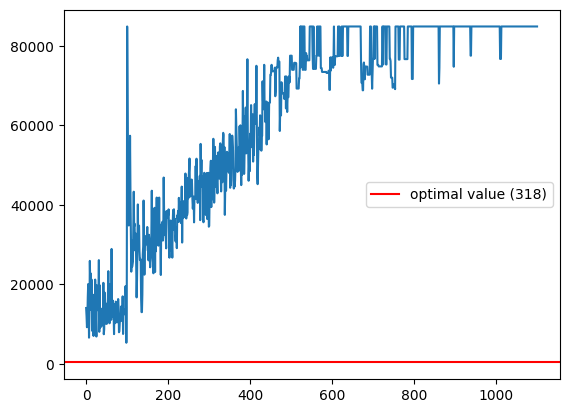

In [9]:
import matplotlib.pyplot as plt

plt.plot(dataset_y)
plt.axhline(y=optimal_value, c="r", label=f"optimal value ({optimal_value})")
plt.legend()